<a href="https://colab.research.google.com/github/anshupandey/Natural_language_Processing/blob/master/Transfer_learning_with_NLP_USE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning using Universal Sentence Encoder

## Import packages

In [1]:
# import the packages
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re

## Downloading the model

In [27]:
model_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5"
embed = hub.load(model_url)


# Compute a representation for each message, showing various lengths supported.
word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be.")
messages = [word, sentence, paragraph]
messages

['Elephant',
 'I am a sentence for which I would like to get its embedding.',
 "Universal Sentence Encoder embeddings also support short paragraphs. There is no hard limit on how long the paragraph is. Roughly, the longer the more 'diluted' the embedding will be."]

In [3]:
embed(messages)

<tf.Tensor: shape=(3, 512), dtype=float32, numpy=
array([[-0.03458562, -0.01799013,  0.00198058, ...,  0.11107819,
        -0.03549766,  0.05680299],
       [ 0.0583339 , -0.08185012,  0.06890938, ..., -0.00923877,
        -0.08695352, -0.01415744],
       [-0.02646177, -0.01911565, -0.04207037, ..., -0.00689673,
         0.01810369, -0.02591053]], dtype=float32)>

In [4]:
embed([word])

<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[-3.45856175e-02, -1.79901309e-02,  1.98056106e-03,
         4.07285243e-02, -1.03552192e-02,  6.11353181e-02,
         3.75662744e-02, -2.61141430e-03,  1.79612488e-02,
        -4.68622409e-02,  2.23783646e-02, -6.13368442e-03,
         1.23131223e-01, -5.41218407e-02, -3.82820815e-02,
        -1.59520172e-02, -3.25838104e-02, -4.26743813e-02,
        -6.10242318e-03, -5.40403016e-02,  5.07151894e-02,
         3.01327072e-02,  5.43540195e-02, -3.47163752e-02,
         8.15961361e-02, -5.37351258e-02, -7.82469008e-03,
        -2.36683246e-02,  1.05400048e-02,  3.99180874e-03,
         1.64847169e-03,  2.44230195e-03, -3.78189608e-02,
         6.28115535e-02,  2.53318413e-03, -7.68776909e-02,
        -1.40247094e-02,  5.79064749e-02,  4.62107360e-02,
        -4.96759973e-02, -7.21461624e-02, -1.11357227e-01,
         2.80168541e-02,  3.13003287e-02, -3.87153998e-02,
         1.03799421e-02, -1.41457111e-01,  1.55930622e-02,
      

In [28]:
for doc in messages:
  print(doc)
  print(len(embed([doc])[0]))
  print("\n")

Elephant
512


I am a sentence for which I would like to get its embedding.
512


Universal Sentence Encoder embeddings also support short paragraphs. There is no hard limit on how long the paragraph is. Roughly, the longer the more 'diluted' the embedding will be.
512




In [6]:
#size of embedding



## Download data

In [29]:
!wget -q https://raw.githubusercontent.com/Tony607/Keras-Text-Transfer-Learning/master/train_5500.txt
!wget -q https://raw.githubusercontent.com/Tony607/Keras-Text-Transfer-Learning/master/test_data.txt

## Decscription of Data

The dataset we use is the TREC Question Classification dataset, There are entirely 5452 training and 500 test samples, that is 5452 + 500 questions each categorized into one of the six labels.

- ABBR - 'abbreviation': expression abbreviated, etc.
- DESC - 'description and abstract concepts': manner of an action, description of sth. etc.
- ENTY - 'entities': animals, colors, events, food, etc.
- HUM - 'human beings': a group or organization of persons, an individual, etc.
- LOC - 'locations': cities, countries, etc.
- NUM - 'numeric values': postcodes, dates, speed,temperature, etc

In [30]:
#Extract lines from .txt and convert to dataframe

def get_dataframe(filename):
    lines = open(filename, 'r').read().splitlines()
    data = []
    for i in range(0, len(lines)):
        label = lines[i].split(' ')[0]
        label = label.split(":")[0]
        text = ' '.join(lines[i].split(' ')[1:])
        text = re.sub('[^A-Za-z0-9 ,\?\'\"-._\+\!/\`@=;:]+', '', text)
        data.append([label, text])

    df = pd.DataFrame(data, columns=['label', 'text'])
    df.label = df.label.astype('category')
    return df

In [31]:
#Assign train data
df_train = get_dataframe("/content/train_5500.txt")
df_test = get_dataframe("/content/test_data.txt")

print(df_train.shape)
print(df_test.shape)

(5452, 2)
(500, 2)


In [32]:
df_train.head(10)

,label,text
0,DESC,How did serfdom develop in and then leave Russ...
1,ENTY,What films featured the character Popeye Doyle ?
2,DESC,How can I find a list of celebrities ' real na...
3,ENTY,What fowl grabs the spotlight after the Chines...
4,ABBR,What is the full form of .com ?
5,HUM,What contemptible scoundrel stole the cork fro...
6,HUM,What team did baseball 's St. Louis Browns bec...
7,HUM,What is the oldest profession ?
8,DESC,What are liver enzymes ?
9,HUM,Name the scar-faced bounty hunter of The Old W...


In [11]:
#Number of categories in dataset
category_counts = len(df_train.label.cat.categories)
category_counts

6

In [12]:
#Convert input into strings  
def UniversalEmbedding(x):
    return embed(tf.squeeze(tf.cast(x,tf.string),axis=1))

In [13]:
UniversalEmbedding([['hello']]).shape

TensorShape([1, 512])

## Model Building

In [14]:
from tensorflow.keras import models,layers

In [15]:
input_layer = layers.Input(shape=(1,),dtype=tf.string)
hub_layer = layers.Lambda(UniversalEmbedding,output_shape=(512,))(input_layer)
dense1 = layers.Dense(256,activation='relu')(hub_layer)
output_layer = layers.Dense(6,activation='softmax')(dense1)

model = models.Model(inputs=[input_layer],outputs=output_layer)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'EncoderTransformer/hidden_layers/tanh_layer_0/dense/bias/part_29:0' shape=(17,) dtype=float32>
  <tf.Variable 'EncoderTransformer/hidden_layers/tanh_layer_0/dense/bias/part_28:0' shape=(17,) dtype=float32>
  <tf.Variable 'EncoderTransformer/hidden_layers/tanh_layer_0/dense/bias/part_27:0' shape=(17,) dtype=float32>
  <tf.Variable 'EncoderTransformer/hidden_layers/tanh_layer_0/dense/bias/part_26:0' shape=(17,) dtype=float32>
  <tf.Variable 'EncoderTransformer/hidden_layers/tanh_layer_0/dense/bias/part_25:0' shape=(17,) dtype=float32>
  <tf.Variable 'EncoderTransformer/hidden_layers/tanh_layer_0/dense/bias/part_24:0' shape=(17,) dtype=float32>
  <tf.Variable 'EncoderTransformer/hidden_layers/tanh_layer_0/dense/bias/part_23:0' shape=(17,) dtype=float32>
  <tf.Variable 'EncoderTransformer/hidden_layers/tanh_layer_0/dense/bias/part_22:0' shape=(17,) dtype=float32>
  

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 lambda (Lambda)             (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 132,870
Trainable params: 132,870
Non-trainable params: 0
_________________________________________________________________


In [33]:
#Convert train text to  an array and labels as get_dummies
xtrain = df_train['text'].tolist()
xtrain = np.array(xtrain).reshape(-1,1)
print(xtrain.shape)
xtest = df_test['text'].tolist()
xtest = np.array(xtest).reshape(-1,1)
print(xtest.shape)


(5452, 1)
(500, 1)


In [34]:
categories = list(pd.get_dummies(df_train['label']).columns)
categories = [i[2:] for i in categories]
categories

['BR', 'SC', 'TY', 'M', 'C', 'M']

In [35]:
ytrain = np.array(pd.get_dummies(df_train['label']))
ytest = np.array(pd.get_dummies(df_test['label']))
print(ytrain.shape)
print(ytest.shape)

(5452, 6)
(500, 6)


In [36]:
model.fit(xtrain,ytrain,epochs=10,batch_size=32,validation_data=(xtest,ytest))

Epoch 1/10
171/171 [==============================] - 7s 40ms/step - loss: 0.0764 - accuracy: 0.9769 - val_loss: 0.1250 - val_accuracy: 0.9540
Epoch 2/10
171/171 [==============================] - 7s 39ms/step - loss: 0.0670 - accuracy: 0.9826 - val_loss: 0.1304 - val_accuracy: 0.9520
Epoch 3/10
171/171 [==============================] - 7s 40ms/step - loss: 0.0605 - accuracy: 0.9848 - val_loss: 0.1216 - val_accuracy: 0.9580
Epoch 4/10
171/171 [==============================] - 7s 39ms/step - loss: 0.0562 - accuracy: 0.9851 - val_loss: 0.1440 - val_accuracy: 0.9500
Epoch 5/10
171/171 [==============================] - 7s 39ms/step - loss: 0.0480 - accuracy: 0.9899 - val_loss: 0.1368 - val_accuracy: 0.9520
Epoch 6/10
171/171 [==============================] - 7s 40ms/step - loss: 0.0422 - accuracy: 0.9923 - val_loss: 0.1459 - val_accuracy: 0.9540
Epoch 7/10
171/171 [==============================] - 7s 41ms/step - loss: 0.0377 - accuracy: 0.9938 - val_loss: 0.1471 - val_accuracy: 0.9520

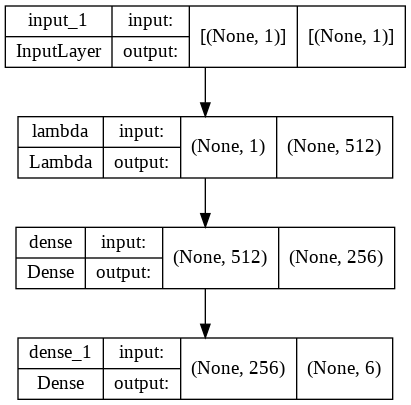

In [21]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, dpi=96)

## Train the model

## Test the model

In [22]:
 model.save_weights("model.h5")

In [23]:
new_doc = ["Who is president of United States of America?","What is price for Harley Davidson?"]
new_doc = np.array(new_doc).reshape(-1,1)

model.load_weights("model.h5")
output = model.predict(new_doc)


In [24]:
output

array([[3.9927625e-07, 3.4952511e-06, 1.6139045e-06, 9.9998546e-01,
        8.8773468e-06, 1.1831874e-07],
       [7.2777939e-06, 3.2830583e-03, 2.0624211e-04, 1.5917187e-05,
        2.1391646e-05, 9.9646616e-01]], dtype=float32)

In [25]:
output2 = [np.argmax(i) for i in output]
output2

[3, 5]

In [26]:
categories = list(pd.get_dummies(df_train['label']).columns)
output2 = [categories[i] for i in output2]
output2

['HUM', 'NUM']